# FIT5202 Assignment 1, Part B: Analysing CSV Data

# Isobel Rowe, 30042585

## Step 01

First, I create a SparkSession object that can be used to create the dataframe from the crime input data.

In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.mongodb.spark:mongo-spark-connector_2.11:2.4.0 pyspark-shell'

# Create entry points to spark
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# Check if there is an existing spark context - if not, make a new one.
sc = SparkContext.getOrCreate()

# If there is no existing spark context, we now create a new context
if (sc is None):
    sc = SparkContext(master="local[*]")
    
# Create spark session
spark = SparkSession(sparkContext=sc)\
        .builder\
        .appName("Assignmnet 1 Part B")\
        .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.11:2.4.0")\
        .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/fit5202_db.wk04_coll")\
        .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/fit5202_db.wk04_coll")\
        .getOrCreate()


## Step 02

Next, I create a dataframe by reading in the crimes statistics .csv file with `spark.read.csv`. I pass in `inferSchema=True` to instruct Spark to automatically infer the datatype for each column, and `header=True` to ensure that the formatting is correct.

Then, I use `.count()` to find the number of records in the data.

In [2]:
# Create dataframe
crimes_df = spark.read.csv('Crime_Statistics_SA_2010_present.csv', inferSchema=True, header=True)

# Display number of records
print("Number of records in the data: ", crimes_df.count())


Number of records in the data:  727408


Additionally, I decided to remove any records in the dataframe that contain a column with a missing value. This is because it is generally an important step in data wrangling to remove nulls, as it helps to ensure the accuracy of any following explorations and calculations.

I used `.na.drop()` to this this, which removed almost 500 records.

In [3]:
# Remove NA values
crimes_df = crimes_df.na.drop()

# Perform another count after deletion
print("Number of records in the data after removing NA: ", crimes_df.count())

Number of records in the data after removing NA:  726921


## Step 03

In this step, I insert the crimes records into MongoDB using the `.mode("overwrite")` method.

In [4]:
# Write to MongoDB
crimes_df.write.format("com.mongodb.spark.sql.DefaultSource").mode("overwrite").save()

# Check to see everything is in order
crimes_df.show(5)


+-------------+-----------------+-------------------+---------------------------+---------------------------+---------------------------+-------------+
|Reported Date|Suburb - Incident|Postcode - Incident|Offence Level 1 Description|Offence Level 2 Description|Offence Level 3 Description|Offence Count|
+-------------+-----------------+-------------------+---------------------------+---------------------------+---------------------------+-------------+
|    1/07/2010|         ADELAIDE|               5000|       OFFENCES AGAINST ...|       FRAUD DECEPTION A...|       Obtain benefit by...|            2|
|    1/07/2010|         ADELAIDE|               5000|       OFFENCES AGAINST ...|       PROPERTY DAMAGE A...|       Other property da...|            2|
|    1/07/2010|         ADELAIDE|               5000|       OFFENCES AGAINST ...|       SERIOUS CRIMINAL ...|        SCT - Non Residence|            1|
|    1/07/2010|         ADELAIDE|               5000|       OFFENCES AGAINST ...|       

## Step 04

Now, I assign the collection to a dataframe using `spark.read()`, and display the schema using `.printSchema()`.

In [5]:
# Create the dataframe
mongo_crimes_df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()

# Display the schema
mongo_crimes_df.printSchema()


root
 |-- Offence Count: integer (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: string (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



## Step 05

Here, I display the count, mean, standard deviation, minimum and maximum values for both the 'Offence Count' and 'Reported Date'. To do this I use `.describe()`, specifiying which columns are wanted and `.show()` to display.

In [6]:
# Display summary statistics
mongo_crimes_df.describe('Offence Count', 'Reported Date').show()


+-------+------------------+-------------+
|summary|     Offence Count|Reported Date|
+-------+------------------+-------------+
|  count|            726921|       726921|
|   mean| 1.171599114621809|         null|
| stddev|0.5788485264995508|         null|
|    min|                 1|    1/01/2011|
|    max|                28|    9/12/2018|
+-------+------------------+-------------+



Are the minimum and maximum of Reported Date correct?

No, I don't think that these minimum and maximum values are correct. As the datatype of the 'Reported Date' column is non-numeric column (a string), there is no way to calculate these values as they rely on a numerical column to do the calculation. If we wanted to find the earliest and latest dates in the dataframe, we would have to use a different methhod of calculation.



## Step 06

In this step, I convert the 'Reported Date' column datatype from a string to an integer. To do this, I first create a user defined function (UDF), which uses datetime and pyspark's DateType to to the necessary conversion. 

Then, to apply this function to the relevant column, I use `.withColumn` which replaces the existing column with the new column which has had the UDF applied to it. Finally, I print the schema and the datatypes to ensure the function worked. 

In [7]:
from datetime import datetime
from pyspark.sql.functions import col,udf
from pyspark.sql.types import DateType

# Create the UDF
date_func =  udf(lambda x: datetime.strptime(x, '%d/%m/%Y'), DateType())
# Replace old date column with new
mongo_crimes_df = mongo_crimes_df.withColumn('Date', date_func(col('Reported Date'))).drop("Reported Date")

# Display
mongo_crimes_df.select(mongo_crimes_df["Date"]).show(5)
mongo_crimes_df.dtypes


+----------+
|      Date|
+----------+
|2012-05-15|
|2012-05-15|
|2012-05-15|
|2012-05-15|
|2012-05-15|
+----------+
only showing top 5 rows



[('Offence Count', 'int'),
 ('Offence Level 1 Description', 'string'),
 ('Offence Level 2 Description', 'string'),
 ('Offence Level 3 Description', 'string'),
 ('Postcode - Incident', 'string'),
 ('Suburb - Incident', 'string'),
 ('_id', 'struct<oid:string>'),
 ('Date', 'date')]

## Step 07

Next, I perform various analytical queries.
- How many level 2 offences are there? Display the list of level 2 offences.
- What is the number of offences against the person?
- How many serious criminal tresspasses with more than 1 offence count?
- What percentage of crimes are offences against the property?

In [8]:
# How many level 2 offences are there? 
level_2 = mongo_crimes_df.select('Offence Level 2 Description').distinct().count()
print("Number of level 2 offences: ", level_2)

# Display the list of level 2 offences.
mongo_crimes_df.select("Offence Level 2 Description").distinct().show()


Number of level 2 offences:  9
+---------------------------+
|Offence Level 2 Description|
+---------------------------+
|       ROBBERY AND RELAT...|
|       PROPERTY DAMAGE A...|
|       SEXUAL ASSAULT AN...|
|       HOMICIDE AND RELA...|
|       ACTS INTENDED TO ...|
|       SERIOUS CRIMINAL ...|
|       OTHER OFFENCES AG...|
|       FRAUD DECEPTION A...|
|       THEFT AND RELATED...|
+---------------------------+



In [9]:
# What is the number of offences against the person?
print("Number of offences against the person: ", \
      mongo_crimes_df.where(mongo_crimes_df['Offence Level 1 Description'] == 'OFFENCES AGAINST THE PERSON').count())


Number of offences against the person:  155909


In [10]:
# How many serious criminal tresspasses with more than 1 offence count?
print("Number of serious criminal tresspasses with more than 1 offence: ",\
      mongo_crimes_df.filter((mongo_crimes_df["Offence Level 2 Description"] == "SERIOUS CRIMINAL TRESPASS") \
                             & (mongo_crimes_df['Offence Count'] > 1)).count())


Number of serious criminal tresspasses with more than 1 offence:  8574


In [11]:
# What percentage of crimes are offences against the property?
print("Percentage of crimes that are offences against the property: ", \
      mongo_crimes_df.filter(mongo_crimes_df['Offence Level 1 Description'] == \
                             "OFFENCES AGAINST PROPERTY" ).count() / mongo_crimes_df.count() * 100)


Percentage of crimes that are offences against the property:  78.55213977860043


## Step 08

Finally, I perform some exploratory data analysis on four different analytical queries.
 
 
First, I find the number of crimes per-year and plot the graph. I decided to use a line graph as I find these are better than bar plots to visualise the change in a variable over time. To do this I first used a `.groupBy()` with a year function from spark to find the rates of crimes per-year. Then, I defined the variables to be used for the plot. And, finally used matplotlib to plot the graph with the specified formatting.

According to the plot below, the number of crimes per-year peaked in 2018 with around 100,000 reported crimes. There was a trough in 2014, where crime rates dropped to about 20,000, dropping from 80,000+ the previous year. Overall, the plot is volatile and it's difficult to find an overall trend - perhaps this is because the data is only for nine years total.


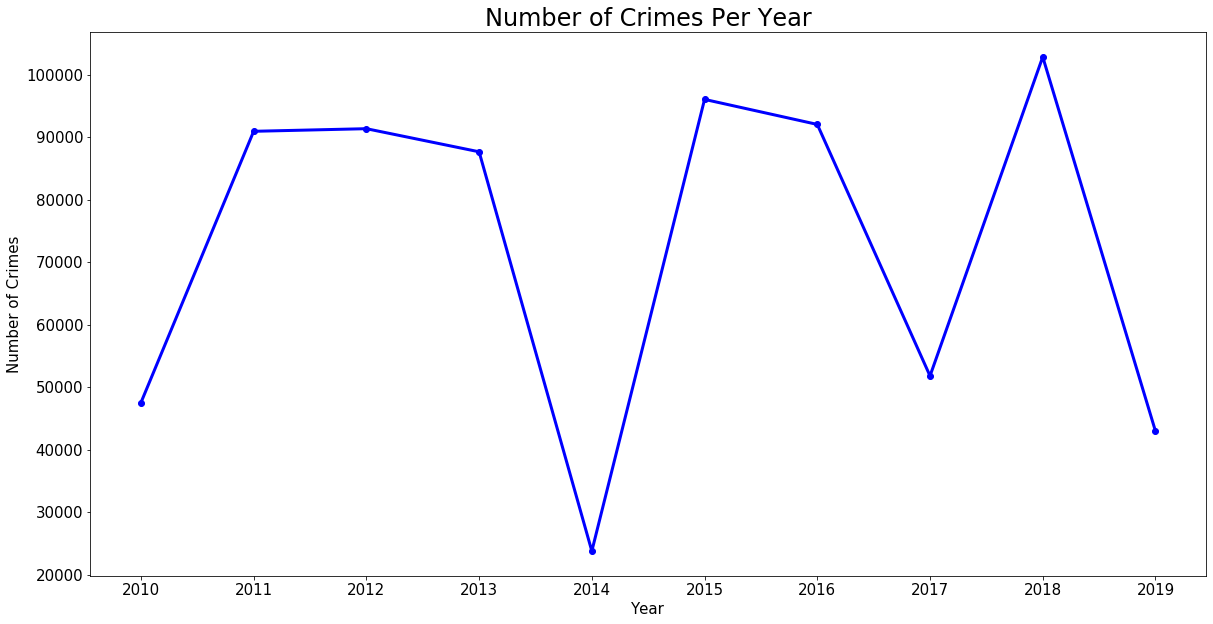

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import year

# GroupBy year using year function from pyspark
df = mongo_crimes_df.groupBy(year('Date')).count().collect()

# Define variables for the graph
y_axis = [row['count'] for row in df]
objects = ('2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019')
y_pos = np.arange(len(objects))

# Plot the graph
plt.figure(figsize=(20,10))
plt.plot(y_pos, y_axis, color='blue', linewidth = 3, marker='o')
plt.xticks(y_pos, objects)
plt.xlabel("Year", fontsize = 15)
plt.ylabel("Number of Crimes", fontsize = 15)
plt.title("Number of Crimes Per Year", fontsize = 24)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()


Next, I find the number of crimes per month and plot the graph.

As evidenced in the plot below, March and July saw the lowest reported crimes, whereas February and October saw the highest. There doesn't appear to be a correlation between seasons and months per this chart, as once again, it is volatile, and fluctuates quite a lot on a month-to-month basis.

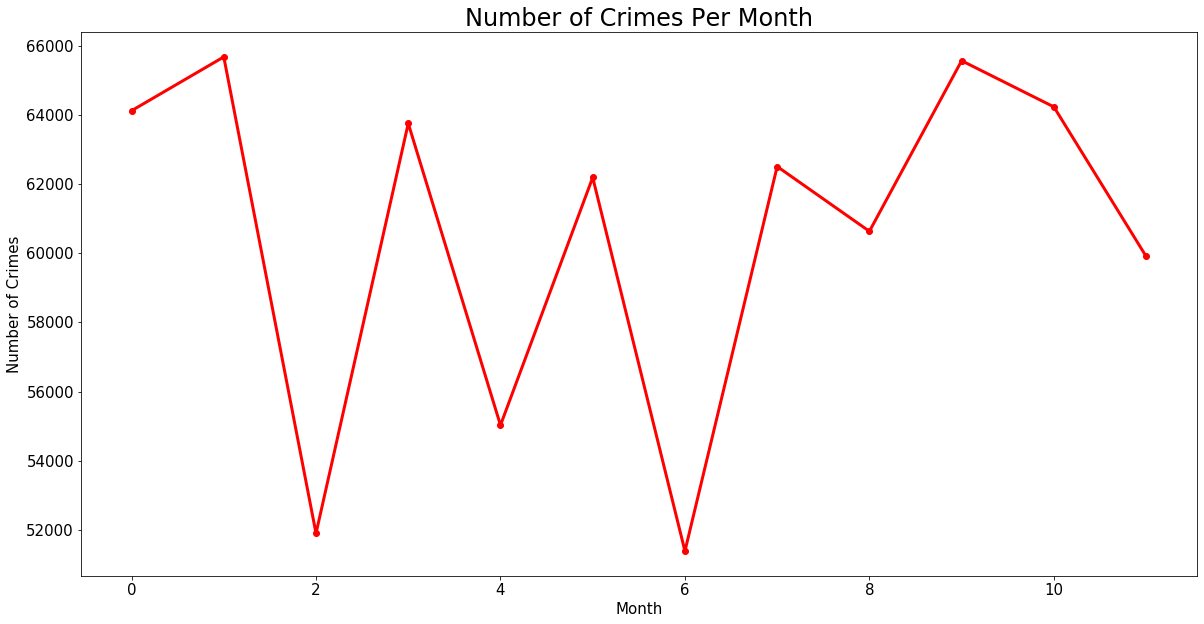

In [14]:
from pyspark.sql.functions import month

# GroupBy year using year function from pyspark
df = mongo_crimes_df.groupBy(month('Date')).count().collect()

# Define variables for the graph
y_axis = [row['count'] for row in df]
objects= ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12')
y_pos = np.arange(len(objects))

# Plot the graph
plt.figure(figsize=(20,10))
plt.plot(y_pos, y_axis, color= "red", linewidth = 3, marker='o')
plt.xlabel("Month", fontsize = 15)
plt.ylabel("Number of Crimes", fontsize = 15)
plt.title("Number of Crimes Per Month", fontsize = 24)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()


Next, I find where most crimes take place.

All the top-20 crime suburbs have seen around 5,000+ crimes over this time period. Adelaide has seen the most crimes out of all the suburbs, with over 20,000. Next is Mount Gambier, which saw about half that of Adelaide with around 10,000.

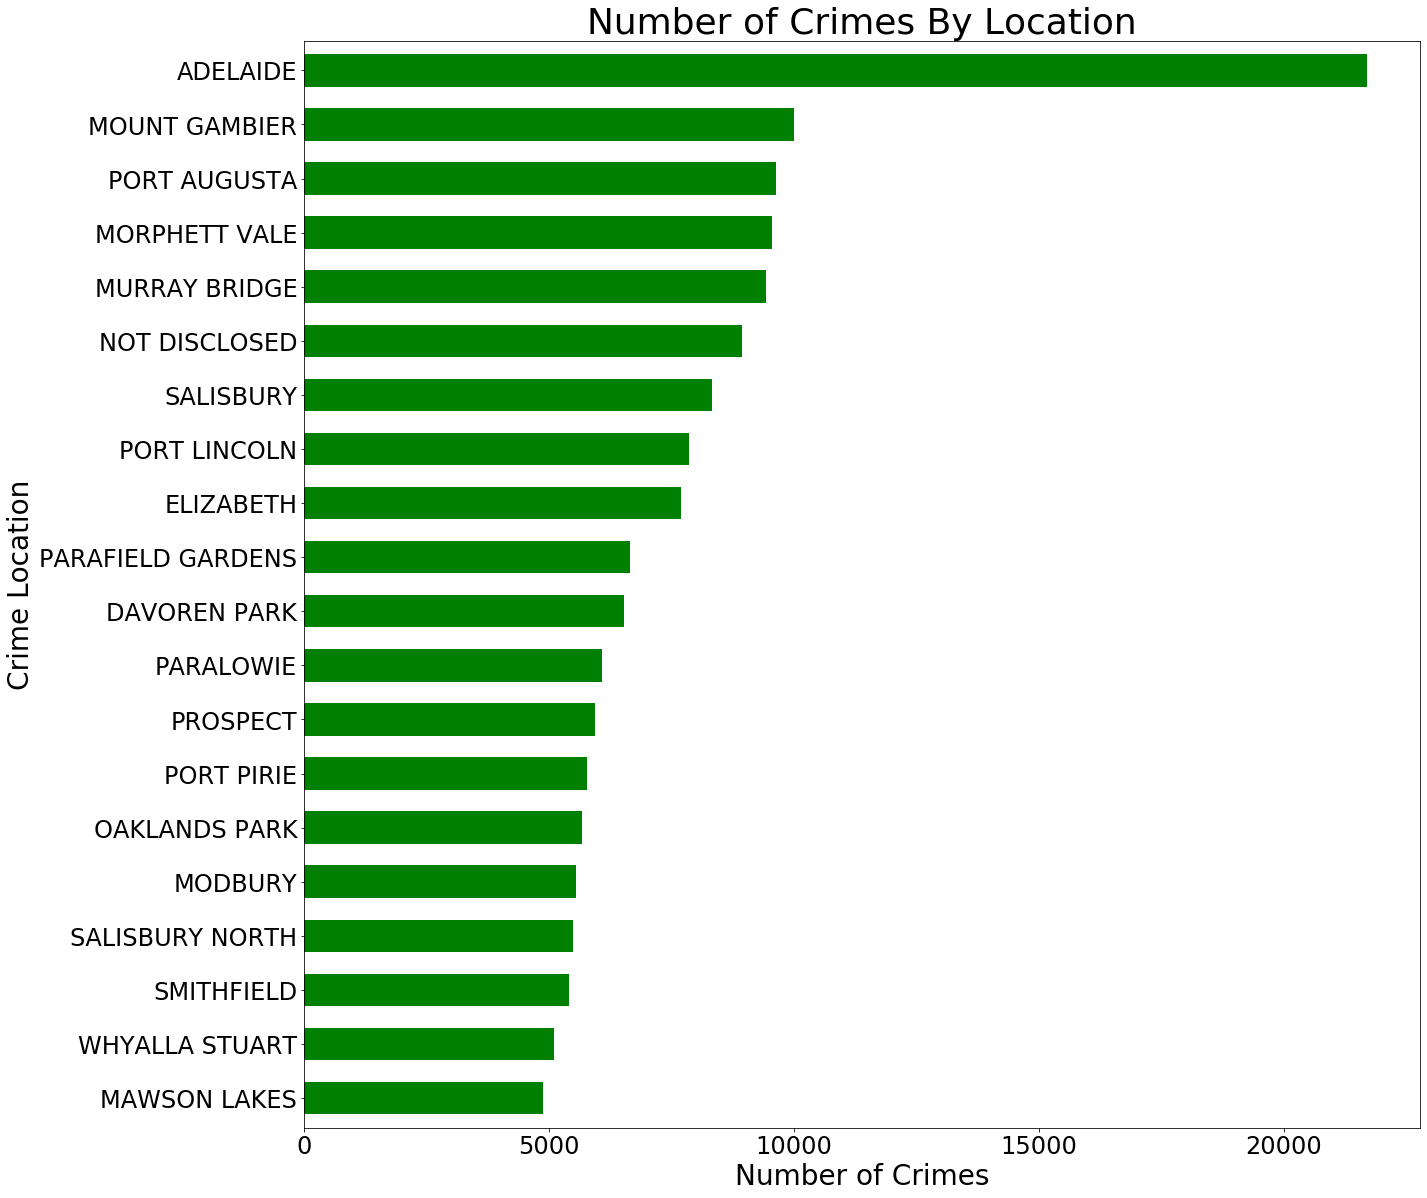

In [15]:
import pandas as pd

# GroupBy suburb
crime_location = mongo_crimes_df.groupBy("Suburb - Incident").count().collect()

# Define variables
location = [item[0] for item in crime_location]
count = [item[1] for item in crime_location]
crime_location = {"location" : location, "count": count}
crime_location = pd.DataFrame(crime_location)
crime_location = crime_location.sort_values(by = "count", ascending  = False)
crime_location = crime_location.iloc[:20]

# Plot the graph
top_20_plot = crime_location .plot(figsize = (20,20), kind = "barh", color = "green", width = 0.6,
                               x = "location", y = "count", legend = False)
top_20_plot.invert_yaxis()
plt.xlabel("Number of Crimes", fontsize = 28)
plt.ylabel("Crime Location", fontsize = 28)
plt.title("Number of Crimes By Location", fontsize = 36)
plt.xticks(size = 24)
plt.yticks(size = 24)
plt.show()
